In [11]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

In [12]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [13]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [14]:
def train_valid_split(dataset, valid_ratio, seed):
    validset_size = int(len(dataset) * valid_ratio)
    trainset_size = len(dataset) - validset_size
    trainset, validset = random_split(dataset, [trainset_size, validset_size], generator=torch.Generator().manual_seed(seed))
    return np.array(trainset), np.array(validset)

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

features = pd.read_csv('./dataset/covid.train.csv')
x_data, y_data = features.iloc[:, 0:117], features.iloc[:, 117]

#try choose your k best features 其原理是根据F检验来挑选特征
k = 24
selector = SelectKBest(score_func=f_regression, k=k)
result = selector.fit(x_data, y_data)
idx = np.argsort(result.scores_)[::-1]
print(f'Top {k} Best feature score ')
print(result.scores_[idx[:k]])
print(f'\nTop {k} Best feature index ')
print(idx[:k])

print(f'\nTop {k} Best feature name')
print(x_data.columns[idx[:k]])
selected_idx = list(np.sort(idx[:k]))
print(selected_idx)
print(x_data.columns[selected_idx])

Top 24 Best feature score 
[90072.43401367 42336.37370139 26889.70377033 18870.55811361
 11290.79919656 10849.62638725 10420.334481   10365.26105926
 10055.85024148  9859.62690961  9636.4254885   9330.74236337
  9180.16305651  8703.90128488  7857.10815311  7840.26399997
  7669.80626316  7634.02832221  7471.14168359  7427.81602428
  7379.57519499  7350.43226583  7200.10012107  7189.72334257]

Top 24 Best feature index 
[101  85  69  53 104  88 105  72  89  56  73  40  57  41 103 102  87  86
  71  70  55  54  39  38]

Top 24 Best feature name
Index(['tested_positive.3', 'tested_positive.2', 'tested_positive.1',
       'tested_positive', 'hh_cmnty_cli.4', 'hh_cmnty_cli.3',
       'nohh_cmnty_cli.4', 'hh_cmnty_cli.2', 'nohh_cmnty_cli.3',
       'hh_cmnty_cli.1', 'nohh_cmnty_cli.2', 'hh_cmnty_cli',
       'nohh_cmnty_cli.1', 'nohh_cmnty_cli', 'ili.4', 'cli.4', 'ili.3',
       'cli.3', 'ili.2', 'cli.2', 'ili.1', 'cli.1', 'ili', 'cli'],
      dtype='object')
[38, 39, 40, 41, 53, 54, 55, 56, 5

In [16]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    '''从 train_data 和 valid_data 中分离出标签 y_train 和 y_valid。这假设最后一列是标签。'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = selected_idx # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': False,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 3000,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-5,              
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

In [18]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days) 
# test_data size: 1078 x 117 (without last day's positive rate)
# 第一个坑，这边应该是取values，如果没有values
train_data, test_data = pd.read_csv('./dataset/covid.train.csv').values, pd.read_csv('./dataset/covid.test.csv').values
# 需要对训练集做划分成训练集和验证集
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'],config['seed'])
# Print out the data size.
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} 
test_data size: {test_data.shape}""")
# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, config['select_all'])

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (2160, 118) 
valid_data size: (539, 118) 
test_data size: (1078, 117)
number of features: 24


# Neural Network Model
Try out different model architectures by modifying the class below.

In [19]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

# 训练过程

In [26]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    # optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9) 
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']*50,
                                 weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                        T_0=2, T_mult=2, eta_min=config['learning_rate'])
    # writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)                     # 前向传播
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).反向传播
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        scheduler.step()
        mean_train_loss = sum(loss_record)/len(loss_record)
        train_losses.append(mean_train_loss)
        # writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        val_losses.append(mean_valid_loss)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        # writer.add_scalar('Loss/valid', mean_valid_loss, step)
        # 为了防止过拟合，使用验证集的损失来衡量模型的好坏，而非训练集的
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            break

    return train_losses, val_losses

# Start Training

In [27]:
model = My_Model(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
train_losses, val_losses = trainer(train_loader, valid_loader, model, config, device)

Epoch [1547/3000]: Train loss: 1.0609, Valid loss: 1.0048


Epoch [1548/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.13it/s, loss=0.83]


Epoch [1548/3000]: Train loss: 1.0528, Valid loss: 1.1430

Model is not improving, so we halt the training session.


Text(0.5, 1.0, 'Val Loss')

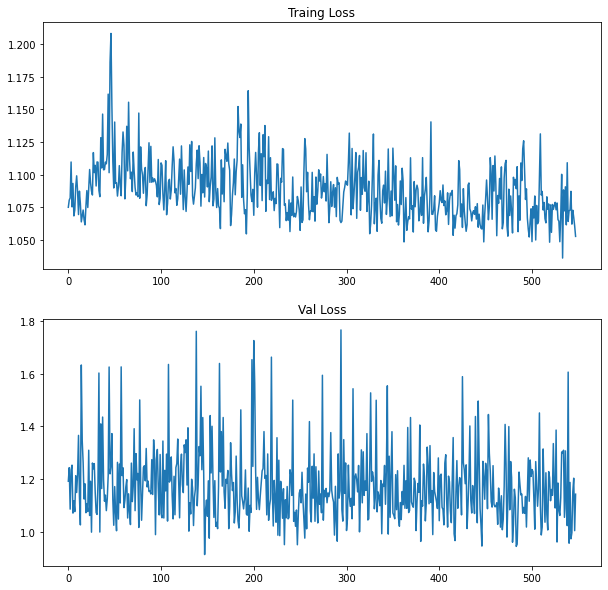

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(train_losses[1000:])
plt.title('Traing Loss')

plt.subplot(212)
plt.plot(val_losses[1000:])
plt.title('Val Loss')

In [30]:
np.sort(val_losses)[0]

0.9141339461008707

select before

In [41]:
best_loss

1.464477042357127

after select proper feature

In [49]:
best_loss

0.984243780374527

modify model + select proper feature

In [14]:
best_loss

1.063470055659612

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

In [29]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device) 
save_pred(preds, 'pred.csv')         

100%|██████████| 5/5 [00:00<00:00, 675.43it/s]


# 代码优化
对现有的变量做相关性检验

In [19]:
from scipy.stats import pearsonr
df = pd.read_csv('./dataset/covid.train.csv')
data = df.values
target = data[:,-1]
feature = data[:,:-1]
cor_val = []
p_val = []
for i in range(len(feature[0])):
    tmp = pearsonr(feature[:,i], target)
    cor_val.append(tmp[0]) #计算第i个特征和第h时刻的结果的相关系数
    p_val.append(tmp[1]) #置信度 
df_pearsonr = pd.DataFrame()
df_pearsonr['rel'] = [abs(x) for x in cor_val]
df_pearsonr['p_val'] = p_val

In [20]:
df_pearsonr

,rel,p_val
0,0.263529,4.080022e-44
1,0.147200,1.521691e-14
2,0.112723,4.300386e-09
3,0.023748,2.174336e-01
4,0.233007,1.332264e-34
...,...,...
112,0.256786,6.691368e-42
113,0.415122,6.322490e-113
114,0.631444,2.945878e-300
115,0.493094,2.209772e-165


In [21]:
df_pearsonr = df_pearsonr.sort_values(['rel'],ascending = False)
df_pearsonr

,rel,p_val
101,0.985357,0.000000
85,0.969593,0.000000
69,0.953333,0.000000
53,0.935388,0.000000
104,0.898437,0.000000
...,...,...
16,0.038334,0.046445
106,0.037205,0.053279
111,0.026965,0.161361
3,0.023748,0.217434


In [29]:
rel_threshold = 0.3
p_threshold = 0.05
selected = []
for i in range(len(df_pearsonr)):
    rel = df_pearsonr.iloc[i].rel
    p = df_pearsonr.iloc[i].p_val
    index = df_pearsonr.iloc[i].name
    if rel > rel_threshold and p < p_threshold:
        selected.append(index)

In [34]:
print(selected)

[101, 85, 69, 53, 104, 88, 105, 72, 89, 56, 73, 40, 57, 41, 103, 102, 87, 86, 71, 70, 55, 54, 39, 38, 114, 98, 82, 66, 50, 108, 92, 76, 60, 44, 115, 99, 67, 83, 51, 113, 97, 81, 65, 49, 109, 93, 77, 21, 61, 116, 100, 84, 68, 52]
